## 1. Binary Classifier

In [67]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, Input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, UpSampling2D, GaussianNoise, BatchNormalization, concatenate, Cropping2D, ZeroPadding2D, AvgPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from skimage.io import imread
from sklearn.model_selection import train_test_split

from skimage.segmentation import mark_boundaries
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import gc
import pickle

gc.enable()

ship_dir = '../data/'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

print(tf.__version__)

2.1.0


In [2]:
# define params for the model
class Params():
    def __init__(self):
        self.batch_size = 128
        self.epochs = 25
        self.image_size = (256, 256)
        
params = Params()

In [3]:
# read the mask data provided by kaggle
seg = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv'))
print(seg.shape[0], 'masks found')
print(seg['ImageId'].value_counts().shape[0], 'unique images found')
seg.sample()

231723 masks found
192556 unique images found


,ImageId,EncodedPixels
166382,b7b1d1660.jpg,549699 2 550465 5 551231 7 551997 10 552764 11...


In [4]:
# identify images that have a mask (ship identification)
from util import agg_ship_count
train_df = agg_ship_count(pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2.csv')), train_image_dir)
train_df.sample(10)

,ImageId,ship_count,has_ship,class
145399,c155beca8.jpg,0,0,no_ship
28208,2576afad4.jpg,0,0,no_ship
26017,22aad5d3f.jpg,0,0,no_ship
134944,b369f35c6.jpg,0,0,no_ship
5126,06dc7b7e3.jpg,0,0,no_ship
29804,279132cd2.jpg,1,1,ship
175023,e8bfb3c9e.jpg,0,0,no_ship
147116,c39cdcb54.jpg,0,0,no_ship
145730,c1c575d35.jpg,0,0,no_ship
119136,9e6eb338f.jpg,0,0,no_ship


In [5]:
# Create a validation set by splitting the training data
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    train_df,
    test_size=0.3,
    stratify = train_df['has_ship']
)

print(train_df.shape[0], 'training samples')
print(valid_df.shape[0], 'validation samples')

133902 training samples
57387 validation samples


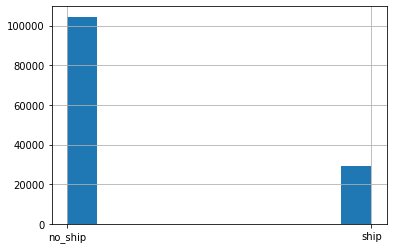

In [6]:
train_df['class'].hist()

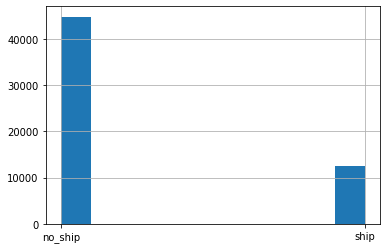

In [7]:
valid_df['class'].hist()

In [8]:
# normalize the image data (255 -> 1.0, 0 -> 0.0)
train_image_generator = ImageDataGenerator(rescale=1./255)
valid_image_generator = ImageDataGenerator(rescale=1./255)

In [9]:
# Training Image Generator
train_data_gen = train_image_generator.flow_from_dataframe(
    train_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=params.image_size,
    class_mode='binary',
    shuffle=True
)

Found 133902 validated image filenames belonging to 2 classes.


In [10]:
# Validation Image Generator
valid_data_gen = valid_image_generator.flow_from_dataframe(
    valid_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=params.image_size,
    class_mode='binary',
    shuffle=True
)

Found 57387 validated image filenames belonging to 2 classes.


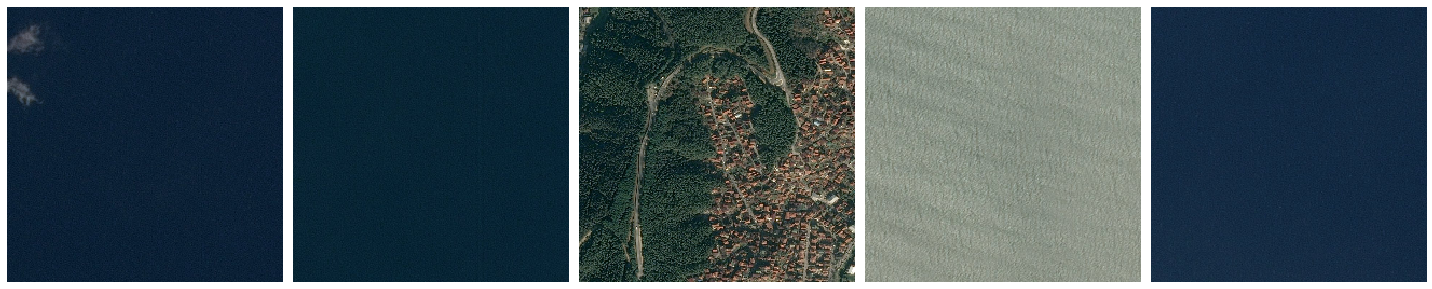

In [11]:
sample_training_images, _ = next(train_data_gen)
from util import plotImages
    
plotImages(sample_training_images[:10])

In [12]:
# model 4-layer CNN (see below for details)
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [13]:
# ADAM optimizer
# Cross Entropy for loss
# Record accurarcy

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

In [18]:
# Save a model checkpoint at each epoch based on validation loss
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints', monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch'
)

# Stop early of overfitting (validation loss does not improve for 2+ epochs)
overfit = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3
)

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='binary_summaries', 
    histogram_freq=0, 
    write_graph=True, 
    write_images=False,
    update_freq='epoch', 
    profile_batch=2, 
    embeddings_freq=0,
    embeddings_metadata=None
)

In [16]:
# Train the model and record history
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_df.shape[0] // params.batch_size,
    epochs=100,
    callbacks=[checkpoint, overfit, tensorboard],
    validation_data=valid_data_gen,
    validation_steps=valid_df.shape[0] // params.batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1046 steps, validate for 448 steps
Epoch 1/100
1045/1046 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.7981WARNING:tensorflow:From /home/b/.conda/envs/airbus/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: checkpoints/assets
1046/1046 [==============================] - 324s 310ms/step - loss: 0.4504 - accuracy: 0.7981 - val_loss: 0.3225 - val_accuracy: 0.8538
Epoch 2/100
1046/1046 [==============================] - 312s 298ms/step - loss: 0.2808 - accuracy: 0.8808 - val_loss: 0.2392 - val_accuracy: 0.8989
Epoch 3/100
1046/1046 [==============================] - 311s 297ms/step - loss: 0.2375 -

In [66]:
# Plot history of loss and accurarcy
def plot_accurary_and_loss(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('images/{}.png'.format(name))
    plt.show()

## Undersample no-ship images

rerun the model with a more even distribution of ship to no ship. In the above model, the guess no ship on every example results in ~79% accurarcy

In [22]:
no_ship_count = train_df[train_df['class'] == 'no_ship'].shape[0]
ship_count = train_df[train_df["class"] == 'ship'].shape[0]

print('no_ship count: {}\nship count:     {}'.format(no_ship_count, ship_count))

no_ship count: 104505
ship count:     29397


In [23]:
no_ship_idxs = train_df[train_df['class'] == 'no_ship'].sample(no_ship_count - ship_count - 5000).index
balanced_train_df = train_df.drop(no_ship_idxs, inplace=False)

In [24]:
no_ship_count = balanced_train_df[balanced_train_df['class'] == 'no_ship'].shape[0]
print('balanced no ship count: {}'.format(no_ship_count))

balanced no ship count: 34397


In [25]:
balanced_model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(
    learning_rate=10e-4, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07,
    name='Adam'
)

reduceLROnPlateautf = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    mode='auto',
    min_delta=0.0001, 
    cooldown=0, 
    min_lr=0
)

earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10
)

balanced_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

balanced_train_data_gen = train_image_generator.flow_from_dataframe(
    balanced_train_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=params.image_size,
    class_mode='binary',
    shuffle=True
)

Found 63794 validated image filenames belonging to 2 classes.


In [26]:
balanced_history = balanced_model.fit(
    balanced_train_data_gen,
    steps_per_epoch=train_df.shape[0] // params.batch_size,
    epochs=100,
    callbacks=[checkpoint, earlyStop, reduceLROnPlateautf, tensorboard],
    validation_data=valid_data_gen,
    validation_steps=valid_df.shape[0] // params.batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1046 steps, validate for 448 steps
Epoch 1/100
  26/1046 [..............................] - ETA: 5:03 - loss: 0.9374 - accuracy: 0.5175

KeyboardInterrupt: 

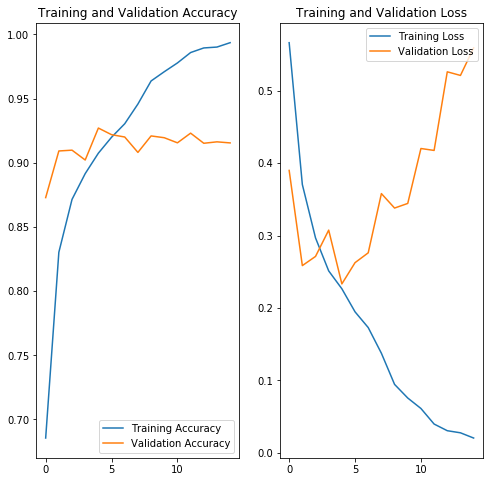

In [67]:
plot_accurary_and_loss(balanced_history, 'balanced_train_w_momentum')

In [ ]:
balanced_512_model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(512, 512 ,3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(
    learning_rate=10e-4, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07,
    name='Adam'
)

reduceLROnPlateautf = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    mode='auto',
    min_delta=0.0001, 
    cooldown=0, 
    min_lr=0
)

earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=10e-4, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07,
    name='Adam'
)

balanced_512_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

balanced_512_train_data_gen = train_image_generator.flow_from_dataframe(
    balanced_train_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=(512, 512),
    class_mode='binary',
    shuffle=True
)

balanced_512_valid_data_gen = valid_image_generator.flow_from_dataframe(
    valid_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=(512, 512),
    class_mode='binary',
    shuffle=True
)

In [ ]:
balanced_512_model.summary()

In [ ]:
balanced_512_history = balanced_512_model.fit(
    balanced_512_train_data_gen,
    steps_per_epoch=balanced_train_df.shape[0] // params.batch_size,
    epochs=100,
    callbacks=[checkpoint, earlyStop, reduceLROnPlateautf, tensorboard],
    validation_data=balanced_512_valid_data_gen,
    validation_steps=valid_df.shape[0] // params.batch_size
)

In [ ]:
plot_accurary_and_loss(balanced_512_history, 'balanced_train_w_momentum_512')

In [77]:
dropout_model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256 ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='binary_summaries', 
    histogram_freq=0, 
    write_graph=True, 
    write_images=True,
    update_freq='epoch', 
    profile_batch=2, 
    embeddings_freq=0,
    embeddings_metadata=None
)

reduceLROnPlateautf = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1, 
    patience=10, 
    verbose=1, 
    mode='auto',
    min_delta=0.0001, 
    cooldown=0, 
    min_lr=0
)

earlyStop = tf.keras.callbacks.tf.keras.callbacks.EarlyStopping(
    monitor='val_accurarcy', 
    min_delta=10e-3, 
    patience=10, 
    verbose=1, 
    mode='max',
    baseline=None, 
    restore_best_weights=False
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=10e-4, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-07,
    name='Adam'
)

dropout_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

dropout_train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True
)

dropout_train_data_gen = dropout_train_image_generator.flow_from_dataframe(
    balanced_train_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True
)

dropout_valid_data_gen = valid_image_generator.flow_from_dataframe(
    valid_df,
    directory=train_image_dir,
    x_col='ImageId',
    y_col='class',
    target_size=(256, 256),
    class_mode='binary',
    shuffle=True
)

Found 63794 validated image filenames belonging to 2 classes.
Found 57387 validated image filenames belonging to 2 classes.


In [78]:
dropout_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 64, 64, 64)      

In [79]:
dropout_history = dropout_model.fit(
    dropout_train_data_gen,
    steps_per_epoch=balanced_train_df.shape[0] // params.batch_size,
    epochs=100,
    callbacks=[checkpoint, earlyStop, reduceLROnPlateautf, tensorboard],
    validation_data=dropout_valid_data_gen,
    validation_steps=valid_df.shape[0] // params.batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 498 steps, validate for 448 steps
Epoch 1/100
498/498 [==============================] - 315s 632ms/step - loss: 0.6212 - accuracy: 0.6345 - val_loss: 0.5006 - val_accuracy: 0.7812
Epoch 2/100
498/498 [==============================] - 306s 615ms/step - loss: 0.5385 - accuracy: 0.7215 - val_loss: 0.5023 - val_accuracy: 0.8542
Epoch 3/100
498/498 [==============================] - 306s 614ms/step - loss: 0.4660 - accuracy: 0.7694 - val_loss: 0.3382 - val_accuracy: 0.8831
Epoch 4/100
498/498 [==============================] - 305s 612ms/step - loss: 0.3863 - accuracy: 0.8230 - val_loss: 0.2782 - val_accuracy: 0.8986
Epoch 5/100
498/498 [==============================] - 305s 612ms/step - loss: 0.3602 - accuracy: 0.8389 - val_loss: 0.2853 - val_accuracy: 0.9058
Epoch 6/100
498/498 [==============================] - 305s 613ms/step - loss: 0.3320 - accuracy: 0.8545 - val_loss: 0.3504 - val_accuracy: 0.8935
Epoch 7/100
498/498 [===

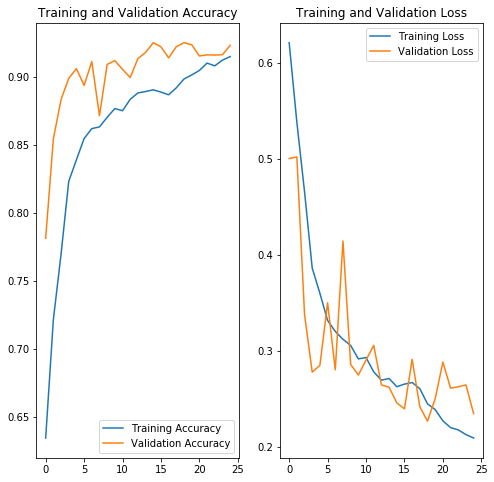

In [ ]:
plot_accurary_and_loss(dropout_history, 'dropout_binary')